<a href="https://colab.research.google.com/github/Tclack88/DS-Unit-2-Kaggle-Challenge/blob/master/module4/assignment_kaggle_challenge_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 4

## Assignment
- [x] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [x] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 60% accuracy (above the majority class baseline).
- [x] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [x] Commit your notebook to your fork of the GitHub repo.
- [x] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading
- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by Kevin Markham, with video
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [x] RandomizedSearchCV / GridSearchCV, for model selection. (See below)
- [ ] Stacking Ensemble. (See below)
- [x] More Categorical Encoding. (See below)

### RandomizedSearchCV / GridSearchCV, for model selection

- _[Introduction to Machine Learning with Python](http://shop.oreilly.com/product/0636920030515.do)_ discusses options for "Grid-Searching Which Model To Use" in Chapter 6:

> You can even go further in combining GridSearchCV and Pipeline: it is also possible to search over the actual steps being performed in the pipeline (say whether to use StandardScaler or MinMaxScaler). This leads to an even bigger search space and should be considered carefully. Trying all possible solutions is usually not a viable machine learning strategy. However, here is an example comparing a RandomForestClassifier and an SVC ...

The example is shown in [the accompanying notebook](https://github.com/amueller/introduction_to_ml_with_python/blob/master/06-algorithm-chains-and-pipelines.ipynb), code cells 35-37. Could you apply this concept to your own pipelines?

### Stacking Ensemble

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```


### More Categorical Encodings

**1.** The article **[Categorical Features and Encoding in Decision Trees](https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931)** mentions 4 encodings:

- **"Categorical Encoding":** This means using the raw categorical values as-is, not encoded. Scikit-learn doesn't support this, but some tree algorithm implementations do. For example, [Catboost](https://catboost.ai/), or R's [rpart](https://cran.r-project.org/web/packages/rpart/index.html) package.
- **Numeric Encoding:** Synonymous with Label Encoding, or "Ordinal" Encoding with random order. We can use [category_encoders.OrdinalEncoder](https://contrib.scikit-learn.org/categorical-encoding/ordinal.html).
- **One-Hot Encoding:** We can use [category_encoders.OneHotEncoder](http://contrib.scikit-learn.org/categorical-encoding/onehot.html).
- **Binary Encoding:** We can use [category_encoders.BinaryEncoder](http://contrib.scikit-learn.org/categorical-encoding/binary.html).


**2.** The short video 
**[Coursera — How to Win a Data Science Competition: Learn from Top Kagglers — Concept of mean encoding](https://www.coursera.org/lecture/competitive-data-science/concept-of-mean-encoding-b5Gxv)** introduces an interesting idea: use both X _and_ y to encode categoricals.

Category Encoders has multiple implementations of this general concept:

- [CatBoost Encoder](http://contrib.scikit-learn.org/categorical-encoding/catboost.html)
- [James-Stein Encoder](http://contrib.scikit-learn.org/categorical-encoding/jamesstein.html)
- [Leave One Out](http://contrib.scikit-learn.org/categorical-encoding/leaveoneout.html)
- [M-estimate](http://contrib.scikit-learn.org/categorical-encoding/mestimate.html)
- [Target Encoder](http://contrib.scikit-learn.org/categorical-encoding/targetencoder.html)
- [Weight of Evidence](http://contrib.scikit-learn.org/categorical-encoding/woe.html)

Category Encoder's mean encoding implementations work for regression problems or binary classification problems. 

For multi-class classification problems, you will need to temporarily reformulate it as binary classification. For example:

```python
encoder = ce.TargetEncoder(min_samples_leaf=..., smoothing=...) # Both parameters > 1 to avoid overfitting
X_train_encoded = encoder.fit_transform(X_train, y_train=='functional')
X_val_encoded = encoder.transform(X_train, y_val=='functional')
```

**3.** The **[dirty_cat](https://dirty-cat.github.io/stable/)** library has a Target Encoder implementation that works with multi-class classification.

```python
 dirty_cat.TargetEncoder(clf_type='multiclass-clf')
```
It also implements an interesting idea called ["Similarity Encoder" for dirty categories](https://www.slideshare.net/GaelVaroquaux/machine-learning-on-non-curated-data-154905090).

However, it seems like dirty_cat doesn't handle missing values or unknown categories as well as category_encoders does. And you may need to use it with one column at a time, instead of with your whole dataframe.

**4. [Embeddings](https://www.kaggle.com/learn/embeddings)** can work well with sparse / high cardinality categoricals.

_**I hope it’s not too frustrating or confusing that there’s not one “canonical” way to encode categorcals. It’s an active area of research and experimentation! Maybe you can make your own contributions!**_

In [0]:
import os, sys
in_colab = 'google.colab' in sys.modules

# If you're in Colab...
if in_colab:
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge.git
    !git pull origin master
    
    # Install required python packages
    !pip install -r requirements.txt
    
    # Change into directory for module
    os.chdir('module4')

In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [0]:
# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv('../data/waterpumps/train_features.csv'), 
                 pd.read_csv('../data/waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv('../data/waterpumps/test_features.csv')
sample_submission = pd.read_csv('../data/waterpumps/sample_submission.csv')

# Split train into train & val. Make val the same size as test.
target = 'status_group'
train, val = train_test_split(train, test_size=len(test),  
                              stratify=train[target], random_state=42)

I will be moving forward with my best model so far (RandomForest of 300 estimators with a onehotencoder) and practicing a little parameter optimization again

###NOTE: I know it's redundant/not the best use of data to do a train/validation split AND do a cross validation search, but this is borth:

- for my practice
- necessary to complete the assignment goal

In [0]:
# Supporting definitions for Wrangle
# this will lower the high cardinality columns, removing much of the noise
def convert_top_100(col_list,df,train):
  for col in col_list:
    global col_top_100
    col_top_100 = train[col].value_counts().index[0:100] # get top 100 of train only, then apply mapping to df in question if applicable
    df[col] = df[col].apply(map_to_100)
  return df
    
def map_to_100(feat):
  if feat in col_top_100:
    return feat
  else:
    return 'other'


  
  
# The main data wrangling function
def wrangle(df):
  
  # Imputer maintains True False, instead of 1,0. I prefer 1 column instead of 4
  bool_cols = ['public_meeting','permit']
  for col in bool_cols:
    df[col] = df[col].fillna(df[col].value_counts().index[0]).astype(int)
                 
  # convert some values to booleans, fill in missing values, replace suspicious values with nans
  high_cardinality_cols = ['wpt_name','subvillage','installer','funder','ward']
  df = convert_top_100(high_cardinality_cols,df,train) # keep the data pure to the "train" data set
  
  df.scheme_manamement = df.scheme_management.fillna('None') # a 'None' category exists, so might as well change nan to None
  
   # change this large count of near-zero outliers to 0, then convert to nan
  df.latitude = df.latitude.replace(-2e-8,0).value_counts()
  
  cols_with_0 = ['latitude','longitude', 'population','construction_year'] # population 1 also exists
  for col in cols_with_0:
    df[col] = df[col].replace(0,np.nan)
    
  df.population = df.population.replace(1,np.nan)

                 
  # remove columns that are "obviously" irrelevant, have too many categorical features, or are redundant
  drop = ['id','date_recorded','num_private','recorded_by','extraction_type',
          'extraction_type_group','water_quality','quantity','source','source_type',
          'waterpoint_type','scheme_name',
          'payment','management']
  
  df = df.drop(columns = drop)
  
  return df

In [9]:
# separate out id columns
train_id = train.id # I don't think this is necessary, but I'm keeping train id
test_id = test.id

# Separate features and labels
train_features = train.drop(columns=[target])
train_labels = train.status_group

val_features = val.drop(columns = [target])
val_labels = val.status_group

test_features = test.copy() # renaming to keep consistancy in variable names

train_features_clean = wrangle(train_features)
val_features_clean = wrangle(val_features)
test_features_clean = wrangle(test_features)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


In [24]:
val_labels.head()

58046             non functional
41184             non functional
27587                 functional
53109                 functional
7245     functional needs repair
Name: status_group, dtype: object

In [0]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint,uniform

In [0]:
rf = make_pipeline(ce.OneHotEncoder(),
                   SimpleImputer(),
                   RandomForestClassifier())

param_distributions = {'simpleimputer__strategy' : ['mean'],
                       'randomforestclassifier__n_estimators': [200],
              'randomforestclassifier__max_depth': randint(20,30),
              'randomforestclassifier__min_weight_fraction_leaf': uniform(0.01,.1)}

search = RandomizedSearchCV(rf,
                            param_distributions = param_distributions,
                            cv = 3,
                            scoring = 'accuracy',
                            n_jobs = -1,
                            n_iter = 25,
                            verbose = 10)

In [50]:
search.fit(train_features_clean,train_labels)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  9.3min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('onehotencoder',
                                              OneHotEncoder(cols=None,
                                                            drop_invariant=False,
                                                            handle_missing='value',
                                                            handle_unknown='value',
                                                            return_df=True,
                                                            use_cat_names=False,
                                                            verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fi

In [66]:
print("best params for this run:", search.best_params_)
print("score for this validation set:", search.best_score_, '(terrible :/)')


pipeline = search.best_estimator_
y_pred = pipeline.predict(val_features_clean)

best params for this run: {'randomforestclassifier__max_depth': 24, 'randomforestclassifier__min_weight_fraction_leaf': 0.010279180572022697, 'randomforestclassifier__n_estimators': 200, 'simpleimputer__strategy': 'mean'}
score for this validation set: 0.7050752630877848 (terrible :/)


## Do over, no randomized search:

In [82]:
rf2 = make_pipeline(ce.OneHotEncoder(use_cat_names=True),
                         SimpleImputer(),
                         RandomForestClassifier(n_estimators = 300,max_depth = 25))

rf2.fit(train_features_clean,train_labels)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['funder', 'installer', 'wpt_name', 'basin',
                                     'subvillage', 'region', 'lga', 'ward',
                                     'scheme_management',
                                     'extraction_type_class',
                                     'management_group', 'payment_type',
                                     'quality_group', 'quantity_group',
                                     'source_class', 'waterpoint_type_group'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown=...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=25,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_imp

In [0]:
y_pred2 = rf2.predict(val_features_clean)

In [131]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report

print('Accuracy:',accuracy_score(rf2.predict(val_features_clean),val_labels))

Accuracy: 0.8012257974648279


### Make submission prediction

In [0]:
submission_pred = rf2.predict(test_features_clean)

In [0]:
submission = pd.concat([test_id,pd.Series(submission_pred)],axis=1).rename(columns={0:'status_group'})
submission.to_csv("Trevor_waterpumps_submission5.csv",index=False)

### Make Confusion Matrix

                         precision    recall  f1-score   support

             functional       0.94      0.71      0.81     10369
functional needs repair       0.01      0.48      0.02        25
         non functional       0.61      0.84      0.71      3964

               accuracy                           0.74     14358
              macro avg       0.52      0.68      0.51     14358
           weighted avg       0.85      0.74      0.78     14358



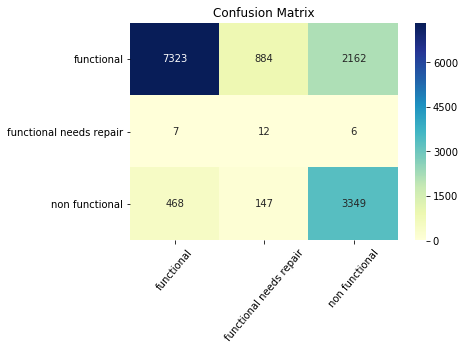

In [132]:
from sklearn.utils.multiclass import unique_labels
import seaborn as sb
import matplotlib.pyplot as plt

labels = unique_labels(y_pred2,val_labels)

cm = confusion_matrix(y_pred2,val_labels)
cm = pd.DataFrame(cm,index = labels,columns = labels)
sb.heatmap(cm,annot=True,fmt='d',cmap = 'YlGnBu')
plt.title("Confusion Matrix")
plt.xticks(rotation=50);

print(classification_report(y_pred2,val_labels))